In [1]:
# written in python 3
# Yicheng Li
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import statsmodels.api as sm
import random

/home/yicheng/.local/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
df = pd.read_pickle('BTC-USD-60.pkl')

In [3]:
df['date'] = pd.to_datetime(df['time'],unit='s').dt.date

In [4]:
group = df.groupby('date')
Daily_Mean_Price = group['close'].mean()

Daily_Mean_Price.head()

date
2016-01-01    433.300405
2016-01-02    435.083883
2016-01-03    431.338427
2016-01-04    433.626442
2016-01-05    433.373114
Name: close, dtype: float64

In [6]:
Daily_Mean_Price=Daily_Mean_Price.reset_index()
Daily_Mean_Price=Daily_Mean_Price.set_index('date')

# Autocorrelation

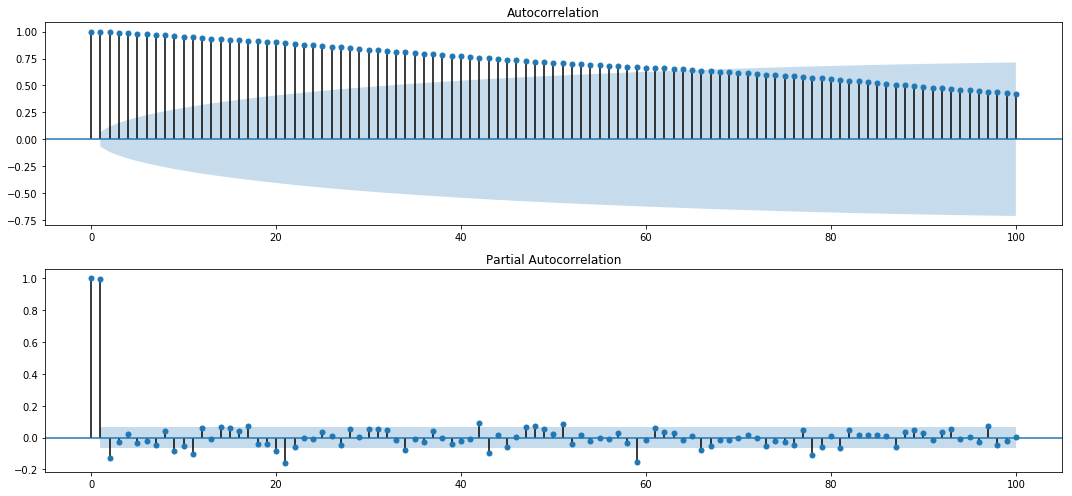

In [33]:
plt.figure(figsize=(15,7))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(Daily_Mean_Price.close.values.squeeze(), lags=100, ax=ax)
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(Daily_Mean_Price.close.values.squeeze(), lags=100, ax=ax)
plt.tight_layout()
plt.show()

# Split training, validation, test sets

In [7]:
from datetime import date
train_start_date = date(2016,1,1)
test_end_date = date(2018,4,3)

In [8]:
total_days = (test_end_date - train_start_date).days + 1
print(total_days)

824


In [9]:
num_days_train, num_days_validate = int(total_days * 0.7), int(total_days * 0.2)
num_days_test = total_days - num_days_train - num_days_validate
print(num_days_train, num_days_validate, num_days_test)

576 164 84


In [47]:
price = np.array(Daily_Mean_Price.values).T
price = price[0]
print(np.shape(price))


(824,)


# Define models

In [13]:
def RMSE(y, y_pred):
    if len(y) != len(y_pred):
        raise ValueError('Length of prediction array is not equal to length of y array.')
    return np.sqrt(sum((y_pred-y)**2)/len(y))

In [14]:
def SMAPE(y, y_pred):
    if len(y) != len(y_pred):
        raise ValueError('Length of prediction array is not equal to length of y array.')
    return np.mean(np.abs(y-y_pred)*2/(np.abs(y)+np.abs(y_pred)))

In [21]:
def normalized_RMSE(y, y_pred):
    if len(y) != len(y_pred):
        raise ValueError('Length of prediction array is not equal to length of y array.')
    return np.sqrt(sum((y_pred/y-1)**2)/len(y))

In [16]:
def RMSE_log_price(y, y_pred):
    if len(y) != len(y_pred):
        raise ValueError('Length of prediction array is not equal to length of y array.')
    return np.sqrt(sum((np.log(y_pred)-np.log(y))**2)/len(y))

In [117]:
# fixed-window linear regression
def train_with_window_size(window_size, loss_func='normalized_RMSE', verbose=True):
    if loss_func != 'normalized_RMSE' and loss_func != 'RMSE_log_price':
        raise ValueError('loss_func must be either normalized_RMSE or RMSE_log_price')
    y = price[window_size:num_days_train]
    W = np.random.rand(window_size)/window_size # initialize as weighted average
    W_old = np.ones(window_size)
    b = 1
    if loss_func=='RMSE_log_price':
        learning_rate = 1e-6
    else:
        learning_rate = 1e-7
    error_list = []

    timestep_random_perm = [x for x in range(num_days_train - window_size)]
    timestep_random_perm = random.sample(timestep_random_perm, len(timestep_random_perm))
    iteration = 0
    batch_len = 0
    gradient = 0
    while iteration < 25000 and np.abs(W_old.dot(W_old.T) - W.dot(W.T))/(W_old.dot(W_old.T)) > 0.00002:
        for timestep in timestep_random_perm:
            iteration += 1
    #         print('iteration ',iteration)
            X = price[timestep:timestep+window_size]
            if batch_len == 10:
                batch_len = 1
                W_old = W
                W = W - learning_rate * gradient * X
                b = b - learning_rate * gradient
                if loss_func == 'normalized_RMSE':
                    gradient = (W.dot(X.T) + b)*1.0/price[timestep+window_size] - 1
                else:
                    gradient = (np.log(W.dot(X.T)+b) - np.log(price[timestep+window_size]))/(W.dot(X.T)+b)
    #             print(gradient, W, b)
            else:
                batch_len += 1
                if loss_func == 'normalized_RMSE':
                    gradient += (W.dot(X.T) + b)*1.0/price[timestep+window_size] - 1
                else:
                    gradient += np.log(W.dot(X.T)+b) - np.log(price[timestep+window_size])

            if iteration % 20 == 0:
                y_pred = []
                for t in range(num_days_train - window_size):
                    X = price[t:t+window_size]
                    y_pred.append(W.dot(X.T) + b)
                if loss_func == 'normalized_RMSE':
                    error = normalized_RMSE(y, y_pred)
                else:
                    error = RMSE_log_price(y, y_pred)
                error_list.append(error)
    
    if verbose:
        plt.figure()
        plt.plot([x*20 for x in range(len(error_list))], error_list)
        plt.title('learining curve')
        plt.ylabel('training loss')
        plt.xlabel('iteration')
        print('Training loss:',error_list[-1])
        y_pred = []
        for t in range(num_days_train - window_size):
            X = price[t:t+window_size]
            y_pred.append(W.dot(X.T) + b)
        print('Training SMAPE:',SMAPE(y, y_pred))

        print(W.dot(W.T))
        print(sum(W)) # should be close to 1 because it's essentially weighted average
        print('W=',W)
        print('b=',b)
    return W, b


In [107]:
# validate
def validate_with_window_size(window_size, W, b, verbose=True):
    y = price[num_days_train:num_days_train+num_days_validate]
    y_pred = []

    for timestep in range(num_days_train-window_size,num_days_train+num_days_validate-window_size):
        X = price[timestep:timestep+window_size]
        y_pred.append(W.dot(X.T) + b)

    validation_SMAPE = SMAPE(y, y_pred)
    if verbose:
        print('Validation SMAPE:', validation_SMAPE)
    
    return validation_SMAPE


Training loss: 0.03659212031380647
Training SMAPE: 0.028419626135705048
0.5046804115690388
0.9832950907408882
W= [0.38858011 0.59471498]
b= 1.0002904954634093
Validation SMAPE: 0.047387362594656784


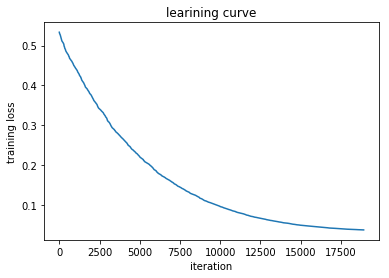

In [95]:
W, b = train_with_window_size(window_size=2, loss_func='normalized_RMSE')
validate_with_window_size(window_size=2, W=W, b=b)

Training loss: 0.03250452982925893
Training SMAPE: 0.020597188560018926
0.5053517010194158
1.0029308073220862
W= [0.4667048  0.53622601]
b= 1.0001716948853936
Validation SMAPE: 0.04150328059178319


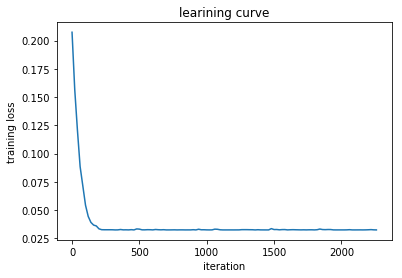

In [100]:
W, b = train_with_window_size(window_size=2, loss_func='RMSE_log_price')
validate_with_window_size(window_size=2, W=W, b=b)

Training loss: 0.0754718344836823
Training SMAPE: 0.07505735595996722
0.865030370983582
0.9300700892855237
W= [0.93007009]
b= 1.0008028882741498
Validation SMAPE: 0.084277638139856


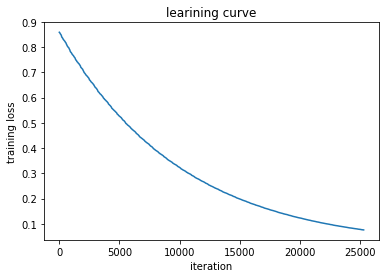

In [103]:
W, b = train_with_window_size(window_size=1, loss_func='normalized_RMSE')
validate_with_window_size(window_size=1, W=W, b=b)

Training loss: 0.027055074038074323
Training SMAPE: 0.017285210993576758
1.0069316692580377
1.0034598493502556
W= [1.00345985]
b= 1.0011025811173881
Validation SMAPE: 0.03454737718984787


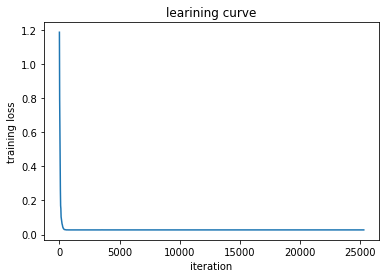

In [102]:
W, b = train_with_window_size(window_size=1, loss_func='RMSE_log_price')
validate_with_window_size(window_size=1, W=W, b=b)

In [64]:
validate_with_window_size(window_size=1, W=np.array([1]), b=0) # Wensi Yin's baseline with window size = 1

Validation SMAPE: 0.035047209389751824


Training loss: 0.037401856349655864
Training SMAPE: 0.027741805214103618
0.3488223656139535
1.0180881320843798
W= [0.29764153 0.37906782 0.34137878]
b= 1.0003330126989742
Validation SMAPE: 0.046256127290820695


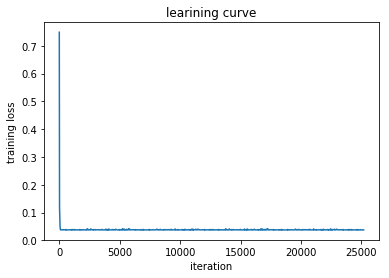

In [105]:
W, b = train_with_window_size(window_size=3, loss_func='RMSE_log_price')
validate_with_window_size(window_size=3, W=W, b=b)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60


Text(0,0.5,'validation SMAPE')

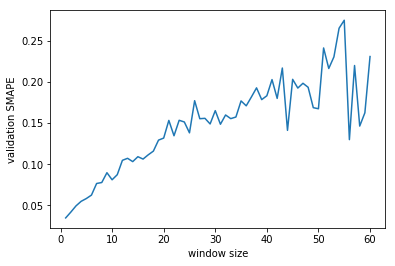

In [118]:
SMAPE_list=[]
for window_size in range(1,61):
    W, b = train_with_window_size(window_size=window_size, loss_func='RMSE_log_price', verbose=False)
    validation_SMAPE = validate_with_window_size(window_size=window_size, W=W, b=b, verbose=False)
    SMAPE_list.append(validation_SMAPE)
    print(window_size)
    
plt.figure()
plt.plot([x+1 for x in range(60)],SMAPE_list)
plt.xlabel('window size')
plt.ylabel('validation SMAPE')